In [1]:
import torch
from torchinfo import summary
import torch.optim as optim
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


from utils.metrics import validation_scores
from models.completion.AE import AE
from utils.datasets import MNIST_SR_completion


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
num_epochs = 10
batch_size = 512
scalefactor = 2
latent_dims = [64]
channels = [32, 64, 128, 256]
in_channels = 1
base_width = 16
model = AE(in_channels=in_channels,
                          latent_dims=latent_dims,
                          channels=channels,
                          base_width=base_width
                          ).to(device)
print(model.sample(torch.randn(1, in_channels, base_width, base_width).to(device)).shape)
summary(model, input_size=[(1, in_channels, base_width, base_width), (1, in_channels, 32, 32)])

torch.Size([1, 1, 32, 32])


Layer (type:depth-idx)                   Output Shape              Param #
AE                                       [1, 1, 32, 32]            --
├─AELREncoder: 1-1                       [1, 64]                   --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           64
│    └─Conv2d: 2-2                       [1, 64, 8, 8]             32,832
│    └─Conv2d: 2-3                       [1, 128, 4, 4]            131,200
│    └─Linear: 2-4                       [1, 64]                   131,136
├─AEDecoder: 1-2                         [1, 1, 32, 32]            --
│    └─Linear: 2-5                       [1, 4096]                 266,240
│    └─ConvTranspose2d: 2-6              [1, 128, 8, 8]            524,416
│    └─ConvTranspose2d: 2-7              [1, 64, 16, 16]           131,136
│    └─ConvTranspose2d: 2-8              [1, 32, 32, 32]           32,800
│    └─Conv2d: 2-9                       [1, 1, 32, 32]            33
├─Conv2d: 1-3                            [1, 1, 32, 

In [3]:
train_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='train')
test_dataset = MNIST_SR_completion(scale_factor=scalefactor, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_train_data = len(train_dataset)
print(f"Dataset Loaded: {len(train_dataset)} training samples, {len(test_dataset)} validation samples")

Dataset Loaded: 60000 training samples, 10000 validation samples


In [4]:
# Adam opt
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = MSELoss()
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

In [14]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0


    for HR, LR, LR_UP in train_loader:

        optimizer.zero_grad()

        recon_imgs = model(LR, LR_UP)

        loss = criterion(recon_imgs, HR)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {total_loss:.2f}")
    model.loss.append(total_loss)


Epoch [1/10] | Loss: 0.88
Epoch [2/10] | Loss: 0.80
Epoch [3/10] | Loss: 0.74
Epoch [4/10] | Loss: 0.68
Epoch [5/10] | Loss: 0.64
Epoch [6/10] | Loss: 0.60
Epoch [7/10] | Loss: 0.57
Epoch [8/10] | Loss: 0.54
Epoch [9/10] | Loss: 0.51
Epoch [10/10] | Loss: 0.49


[]

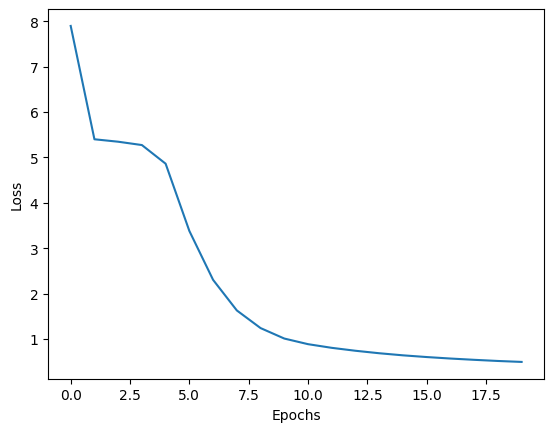

In [15]:
plt.plot(model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot()

In [16]:
HR, LR, LR_UP = test_dataset.get_samples(1000)
SR = model.sample(LR)

In [17]:
def show_image(x, low_res, superres, n):

    fig, axs = plt.subplots(4, n, figsize=(20, 6))
    for i in range(n):
        #figure description above every row in the middle
        if i == 0:
            axs[0, i].set_title('Original')
            axs[1, i].set_title('Low Resolution')
            axs[2, i].set_title('Super Resolution')
            axs[3, i].set_title('Low Resolution Upscaled')

        axs[0, i].imshow(x[i].permute(1, 2, 0).detach().cpu().numpy(),)
        axs[0, i].axis('off')

        axs[1, i].imshow(low_res[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[1, i].axis('off')

        axs[2, i].imshow(superres[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[2, i].axis('off')

        axs[3, i].imshow(LR_UP[i].permute(1, 2, 0).detach().cpu().numpy())
        axs[3, i].axis('off')

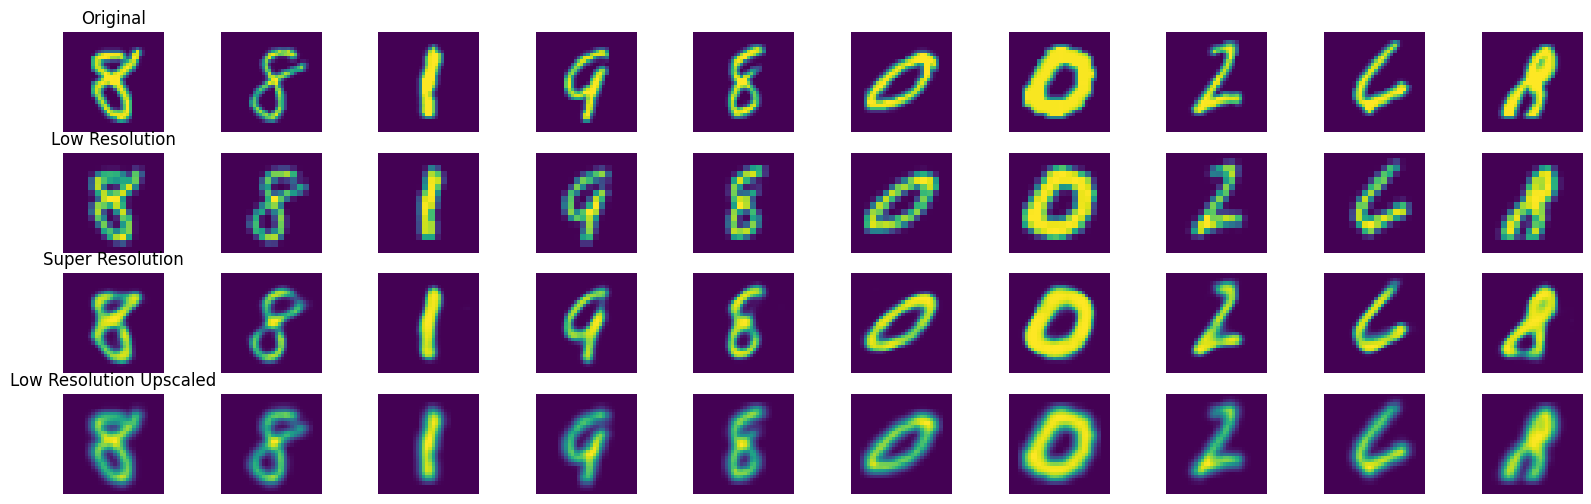

In [18]:
show_image(HR, LR, SR, 10)

In [19]:
psnr_val, ssim_val, lpips_val, brisque_val, psnr_consistency_val, mse_diversity_val, lpips_diversity_val = validation_scores(model, HR, LR)
print("PSNR:", psnr_val)
print("SSIM:", ssim_val)
print("LPIPS:", lpips_val)
print("BRISQUE:", brisque_val)
print("PSNR Consistency:", psnr_consistency_val)
print("MSE Diversity:", mse_diversity_val)
print("LPIPS Diversity:", lpips_diversity_val)

PSNR: 24.63234519958496
SSIM: 0.9374621510505676
LPIPS: 0.052533093839883804
BRISQUE: 81.36880493164062
PSNR Consistency: 33.5381965637207
MSE Diversity: 8.940213068145734e-17
LPIPS Diversity: 4.718296612689018e-12
